# Machine Learning
Existem dois tipos de problema em Machine Learning: supervisionados e não supervisionados.

Os problemas supervisionados são aqueles em que cada observação do conjunto de dados possui a ele associado o valor correto da variável de interesse, que chamamos de rótulo. Nosso problema é supervisionado, pois para cada observação (valor de tempo), conhecemos o valor correto do número de remessas (nosso rótulo). O objetivo dos modelos supervisionados é encontrar uma função que mapeie nosso input no valor correto da variável de interesse. Por exemplo: dados os valores de remessas dos últimos n dias, qual é o valor do número de remessas no dia seguinte?

Os problemas não supervisionados são aqueles que não possuem um rótulo para cada observação do conjunto de dados. Por exemplo: dadas as características da minha base de clientes, separe esses clientes em 4 grupos (ou clusters) de características semelhantes. Isso acontece muito em marketing com segmentação de clientes. Nesse case, não vamos lidar com algoritmos não supervisionados.

## Time Series
Para modelar séries temporais com algoritmos de machine learning, precisamos construir o problema como um problema supervisionado. Uma possibilidade é a seguinte: dados os valores de remessa dos últimos n dias, encontre o valor de remessas do próximo dia.

Para construir as observações que serão usadas para treinar esse modelo, precisamos adaptar nossa série temporal da seguinte maneira: pegamos todos os grupos possíveis de (n+1) dias **seguidos** dentro do nosso intervalo de tempo. Cada um desses grupos será uma observação.Os n primeiros dias seguidos de cada observação será o input do modelo, e o (n+1)º será o rótulo daquela observação.

Desse modo, o nosso algoritmo será treinado para, olhando para n dias em sequência, determinar qual é o valor de remessas no dia posterior. Esse algoritmo só é capaz de fazer a previsão de 1 dia. Para prevermos os 30 dias de setembro/2020, o que fazemos é rodar iterativamente esse algoritmo: prevemos 01/set e, em seguida, damos esse valor como input para prever dia 02/set. Repetimos o processo até chegar no dia 30/set.

Para nossa modelagem, escolherei o algoritmo de Deep Learning chamado de LSTM (Long Short Term Memory). Esse algoritmo é uma adaptação do RNN (Recurrent Neural Network), que é um tipo de estrutura de Rede Neural. O LSTM é considerado um modelo cutting edge. Ele é usado atualmente para tarefas como traduções feitas por máquina (e.g. Google Translate), sugestões de próxima palavra (e.g. teclado de celular), reconhecimento de voz (e.g. converter áudio pra texto ou vice versa), spam classification (e.g. esse email é SPAM?), entre outras.

### Um aviso antes da modelagem
Algoritmos de Machine Learning têm ótima performance para variados tipos de tarefas. Entretanto, historicamente, modelar séries temporais não é uma delas. Tem um artigo da USP entitulado *Evaluation of statistical and machine learning models for time series prediction: Identifying the state-of-the-art and the best conditions for the use of each model* que mostra que modelos SARIMA são consistentemente são melhores que modelos como LSTM, exceto para tarefas bem específicas.

Em geral, os algoritmos construídos especificamente para time series (e.g. família ARIMA) ou as regressões são preferíveis para modelar séries temporais, por serem mais robustas para essa tarefa. Algoritmos de Machine Learning costumam fazer previsões não eficientes (i.e. não muito melhores do que modelos de benchmark pouco inteligentes). Esses algoritmos tendem a repetir muito fortemente o padrão dos n dias anteriores na previsão dos dias seguintes. Como normalmente n é um número pequeno se comparado com o intervalo total da série temporal, na prática esses algoritmos fazem uma espécie de média móvel dos últimos n dias na previsão dos dias seguintes.

Para que seja possível que o algoritmo capture a estrutura de toda a série temporal para fazer a previsão do próximo ponto, ao invés de simplesmente fazer uma espécie de média móvel dos últimos n dias, é necessário que n seja comparável ao range total da série. Mas isso faria com que tivéssemos apenas 1 observação, dada a maneira como construímos nossas observações. Isso é um problema, porque algoritmos de Deep Learning, como LSTM, precisam de uma grande quantidade de observações para serem treinados.

Portanto, apesar do LSTM ser capaz de capturar diferentes tipos de estruturas no mapeamento do input no output, na prática não conseguimos treiná-lo de forma apropriada, por falta de observações, ao longo de todo o range de tempo disponível. Acabamos tendo que setar um n pequeno, de modo a ter observações suficientes para o treinamento. Nosso algoritmo acabará sendo, portanto, uma espécie de média móvel dos últimos n dias para fazer a previsão do próximo dia.

Para reforçar o ponto: suponha que existissem muitos universos paralelos. Em cada um desses universos teríamos uma série de remessas entre 10/2019 e 08/2020. Assim, pra cada universo, poderíamos construir apenas 1 observação para treinar o LSTM, onde o input seria o valor das remessas no intervalo inteiro da série (exceto o último dia) e o rótulo seria o número de remessas no último dia. i.e., temos n = (tamanho da série -1). Cada universo daria 1 observação, mas como temos muitos universos, teríamos muitas observações e o LSTM seria capaz de entender a estrutura da relação entre os inputs e o output. Nesse caso, o LSTM seria um excelente modelo para prever a série.

**Eu sugiro fortemente, então, que não seja usado um algoritmo de Machine Learning para fazer o forecast das remessas para o mês de setembro/2020**.

Ainda assim, como um dos objetivos do case é avaliar minha capacidade de implementar um modelo de Machine Learning, vou fazê-lo aqui.

Como uma primeira abordagem, vamos modelar cada cluster isoladamente. Nesse notebook estudaremos o cluster A.

## O modelo LTSM que será treinado
O modelo que treinaremos é um LSTM. Para fazer a previsão das remessas de um certo dia, o modelo olha para as remessas de uma janela dos n dias anteriores. A imagem abaixo mostra um diagrama do modelo em fase de treinamento, com n=23.

Após fazer a previsão para um certo dia, o modelo compara o valor previsto com o valor correto (rótulo, ou label) que temos disponível no conjunto de treinamento. Comparando esses dois valores, o modelo ajusta seus parâmetros (os pesos/weights da rede neural) de modo a minimizar a função de custo (que é o erro quadrático entre o valor previsto e o rótulo). Após treinados os pesos da rede neural, podemos usar o modelo para fazer previsões out of sample.

![](https://www.tensorflow.org/tutorials/structured_data/images/lstm_1_window.png)

In [31]:
#carregando as bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse, meanabs
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
import tensorflow as tf
warnings.filterwarnings("ignore")

#estou rodando esse notebook no Kaggle.com, para ter acesso a bibliotas de Deep Learning
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/plannera/dados.csv


In [32]:
#Carregando nossos dados
df = pd.read_csv('../input/plannera/dados.csv', parse_dates=['DataEntrega'], index_col='DataEntrega')

dependent_variable = 'Remessas_A'
df = df[dependent_variable].to_frame()

df.head()

,Remessas_A
DataEntrega,
2019-10-01,466.0
2019-10-02,496.0
2019-10-03,574.0
2019-10-04,476.0
2019-10-05,11.0


In [33]:
#Assim como fizemos nas modelagens de Time Series e de Regressão Linear, vamos diferenciar nossa série com lag de 7
#para torná-la estacionária
df_differenced = df.diff(7).dropna()

In [34]:
#train test split
train = df_differenced[:'2020-07-31']
test = df_differenced['2020-08-01':]

In [35]:
#Modelos de machine learning são estocásticos. Para acelerar sua convergência, fazemos a normalização do conjunto de dados
#scaling
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [36]:
#a classe TimeseriesGenerator transforma nossa time series num problema supervisionado, com uma janela de input seguida 
#do output

#usaremos uma janela de 20 dias (n=20).

#Assim, nosso modelo olha pros 20 dias anteriores para fazer a previsão do próximo. O valor de 20 é um hiperparâmetro
#que pode ser otimizado
n_input = 20
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)

In [37]:
#Declarando nosso modelo LSTM
#os valores abaixo são hiperparâmetros que podem ser otimizados
model = Sequential()
model.add(LSTM(8, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

obs: Normalmente, além dos conjuntos de treinamento e de test, eu criaria um outro conjunto, de validação. O conjunto de validação é usado para procurarmos os hiperparâmetros ótimos do LSTM, e para avaliar o grau de overfitting de cada modelo.

In [38]:
#treinando o modelo
history = model.fit_generator(generator,epochs=90)

Epoch 1/90
47/47 [==============================] - 1s 7ms/step - loss: 0.1256
Epoch 2/90
47/47 [==============================] - 0s 6ms/step - loss: 0.0257
Epoch 3/90
47/47 [==============================] - 0s 7ms/step - loss: 0.0194
Epoch 4/90
47/47 [==============================] - 0s 6ms/step - loss: 0.0142
Epoch 5/90
47/47 [==============================] - 0s 6ms/step - loss: 0.0160
Epoch 6/90
47/47 [==============================] - 0s 7ms/step - loss: 0.0130
Epoch 7/90
47/47 [==============================] - 0s 7ms/step - loss: 0.0113
Epoch 8/90
47/47 [==============================] - 0s 6ms/step - loss: 0.0108
Epoch 9/90
47/47 [==============================] - 0s 7ms/step - loss: 0.0100
Epoch 10/90
47/47 [==============================] - 0s 6ms/step - loss: 0.0158
Epoch 11/90
47/47 [==============================] - 0s 6ms/step - loss: 0.0083
Epoch 12/90
47/47 [==============================] - 0s 7ms/step - loss: 0.0088
Epoch 13/90
47/47 [==============================

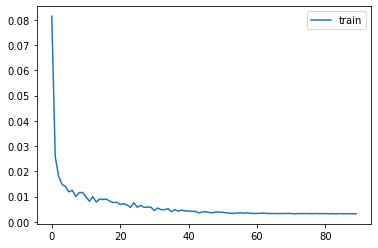

In [39]:
#plotando a função de custo contra o número de iterações (épocas). Como a função de custo estabiliza, nossa
#otimização convergiu.
history.history

plt.plot(history.history['loss'], label='train')
plt.legend();

In [40]:
#tamanho do test set (será usado para determinar quantos time steps de previsão faremos)
test_set_size = len(test)

# encontrar a previsao dentro do test set
pred_list = []

#pegamos os últimos n_input valores do training set (aqui n_input = 12), que serão o input pro modelo calcular o 
#primeiro time step dentro do test set
batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(test_set_size):   
    #adiciona como último elemento da lista a previsao feita para o próximo time step, tendo como input 
    #os n_input time steps anteriores
    pred_list.append(model.predict(batch)[0]) 
    #para encontrar o input para a previsão do time step seguinte, se desfaz do primeiro time step e adiciona
    #a previsãoi recém feita como último time step
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [41]:
#cria um dataframe com todos os time steps previstos
#aqui os valores previstos já estão tendo o scaling invertido
#os índices (datas) correspondem aos n_input últimos time steps do nosso dataframe original, porque o test set 
#também corresponde.
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=df[-test_set_size:].index, columns=['Prediction_dif'])

df_test = pd.concat([df,df_predict], axis=1)

In [42]:
#criando um dataframe para guardar as previsões do modelo
df_test['Prediction'] = df_test['Prediction_dif'].copy()
df_test['Prediction'] = np.nan

#invertendo, na mão, a diferenças de lag 7 que fizemos (isso não foi necessário no ARIMA, que já faz isso de 
#forma automatizada)
df_test["Prediction"][df_test.index <= pd.to_datetime("2020-08-07")] = df_test[dependent_variable].shift(7) + df_test["Prediction_dif"]

for d in pd.date_range("2020-08-08", "2020-08-31"):
    df_test.loc[d, "Prediction"] = df_test.loc[d - pd.Timedelta("7d"), "Prediction"] + df_test.loc[d, "Prediction_dif"]

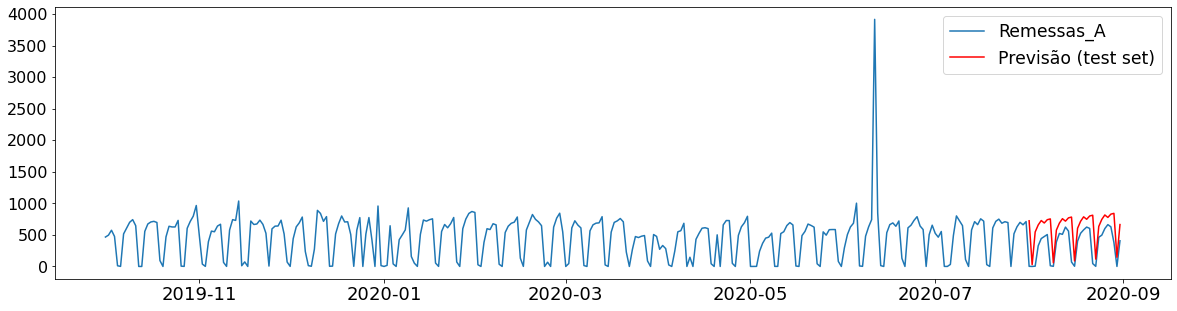

In [44]:
#plotando as previsões do test set
plt.figure(figsize=(20, 5))
plt.plot(df_test.Prediction.index, df_test[dependent_variable], label=dependent_variable)
plt.plot(df_test.Prediction.index, df_test['Prediction'], color='r', label='Previsão (test set)')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

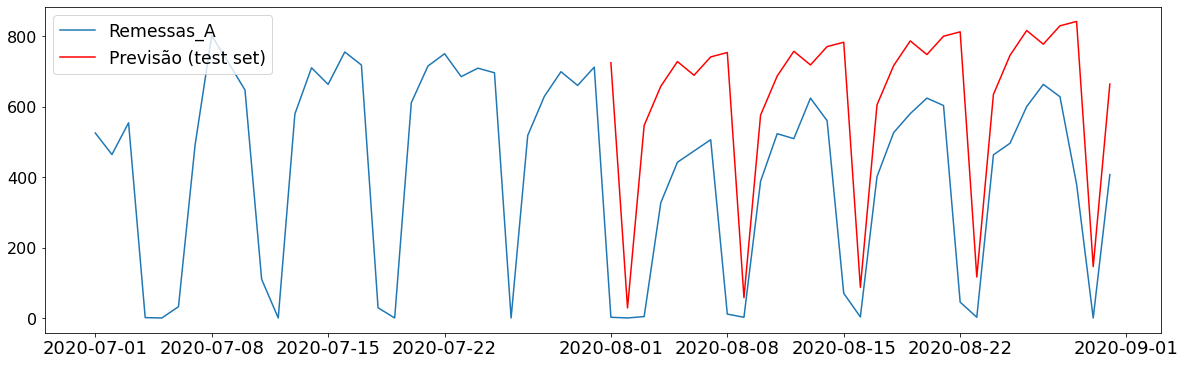

In [45]:
#zoom no plot das previsões do test set
df_plot = df_test.loc['2020-07-01':]
plt.figure(figsize=(20, 6))
plt.plot(df_plot.Prediction.index, df_plot[dependent_variable], label=dependent_variable)
plt.plot(df_plot.Prediction.index, df_plot['Prediction'], color='r', label='Previsão (test set)')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

### Avaliando o modelo
Observe como as previsões do modelo no test set são uma espécia de média do comportamento da série nos 20 dias anteriores, conforme havíamos previsto. Essa "média", ajustada pela sazonalidade, se repete a cada 7 dias.

Definitivamente esse é um modelo inferior aos modelos anteriores (time series e regressão linear). O MAE (mean absolute error) obtido no conjunto de teste é mostrado abaixo. Perceba como é bem maior que os MAE obtidos por esses outros modelos.

obs: como o treinamento de redes neurais é um processo estocástico, cada vez que o notebook for rodada obteremos um valor diferente para o MAE.

In [46]:
pred_actual_meanabs = meanabs(df_test[dependent_variable]['2020-08-01':],df_test['Prediction']['2020-08-01':])
print("meanabs: ", pred_actual_meanabs)

meanabs:  273.46050674684585


# Forecast

In [47]:
#usaremos todos os nossos dados para treinamento
train = df_differenced[:]


#scaling
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)

#a classe TimeseriesGenerator transforma nossa time series num problema supervisionado, com uma janela de input 
#seguida do output
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)

#declarando o modelo
model = Sequential()
model.add(LSTM(8, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

#treinando o modelo
history = model.fit_generator(generator,epochs=90)


Epoch 1/90
52/52 [==============================] - 1s 6ms/step - loss: 0.1634
Epoch 2/90
52/52 [==============================] - 0s 7ms/step - loss: 0.0281
Epoch 3/90
52/52 [==============================] - 0s 7ms/step - loss: 0.0173
Epoch 4/90
52/52 [==============================] - 0s 7ms/step - loss: 0.0166
Epoch 5/90
52/52 [==============================] - 0s 6ms/step - loss: 0.0152
Epoch 6/90
52/52 [==============================] - 0s 6ms/step - loss: 0.0124
Epoch 7/90
52/52 [==============================] - 0s 6ms/step - loss: 0.0124
Epoch 8/90
52/52 [==============================] - 0s 7ms/step - loss: 0.0157
Epoch 9/90
52/52 [==============================] - 0s 6ms/step - loss: 0.0146
Epoch 10/90
52/52 [==============================] - 0s 7ms/step - loss: 0.0081
Epoch 11/90
52/52 [==============================] - 0s 6ms/step - loss: 0.0132
Epoch 12/90
52/52 [==============================] - 0s 6ms/step - loss: 0.0104
Epoch 13/90
52/52 [==============================

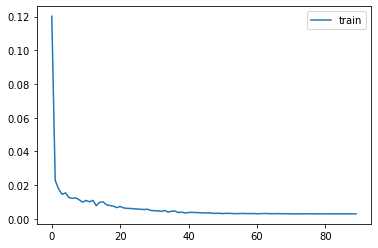

In [48]:
#plotando a função de custo contra o número de iterações (épocas). Como a função de custo estabiliza, nossa 
#otimização convergiu.

plt.plot(history.history['loss'], label='train')
plt.legend();

In [49]:
#tamanho do test set (será usado para determinar quantos time steps de previsão faremos)
test_set_size = 30

# encontrar a previsao dentro do test set
pred_list = []

#agora o training set é todo nosso dataset
#pegamos os últimos n_input valores do training set, que serão o input pro modelo calcular o primeiro time step fora 
#do conjunto de treinamento
batch = np.append(train, test)[-n_input:].reshape((1, n_input, n_features))

for i in range(test_set_size):   
    #adiciona como último elemento da lista a previsao feita para o próximo time step, tendo como input os n_input 
    #time steps anteriores
    pred_list.append(model.predict(batch)[0]) 
    #para encontrar o input para a previsão do time step seguinte, se desfaz do primeiro time step e adiciona a previsão 
    #recém feita como último time step
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [50]:
#cria um dataframe com todos os time steps previstos
#aqui os valores previstos já estão tendo a transformação invertida
#os índices (datas) correspondem aos n_input últimos time steps do nosso dataframe original, porque o test set também
#corresponde.

forecast_date_range = pd.date_range(start='2020-09-01', end='2020-09-30', freq='D')
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=forecast_date_range, columns=['Prediction_dif'])

df_test = pd.concat([df,df_predict], axis=1)

In [51]:
#criando um dataframe para guardar as previsões

df_test['Prediction'] = df_test['Prediction_dif'].copy()
df_test['Prediction'] = np.nan

#invertendo, na mão, a diferenças de lag 7 que fizemos (isso não foi necessário no ARIMA, que já faz isso de
#forma automatizada)
df_test["Prediction"][df_test.index <= pd.to_datetime("2020-09-07")] = df_test[dependent_variable].shift(7) + df_test["Prediction_dif"]

for d in pd.date_range("2020-09-08", "2020-09-30"):
    df_test.loc[d, "Prediction"] = df_test.loc[d - pd.Timedelta("7d"), "Prediction"] + df_test.loc[d, "Prediction_dif"]

In [65]:
#df com nosso forecast
df_forecast = df_test.copy()
df_forecast = df_forecast.tail(30).Prediction.to_frame().rename(columns={'Prediction': 'forecast'})
df_forecast

,forecast
2020-09-01,494.253543
2020-09-02,598.340099
2020-09-03,661.401038
2020-09-04,626.444122
2020-09-05,378.474010
2020-09-06,-1.505031
2020-09-07,405.509719
2020-09-08,492.773742
2020-09-09,596.867285
2020-09-10,659.933270


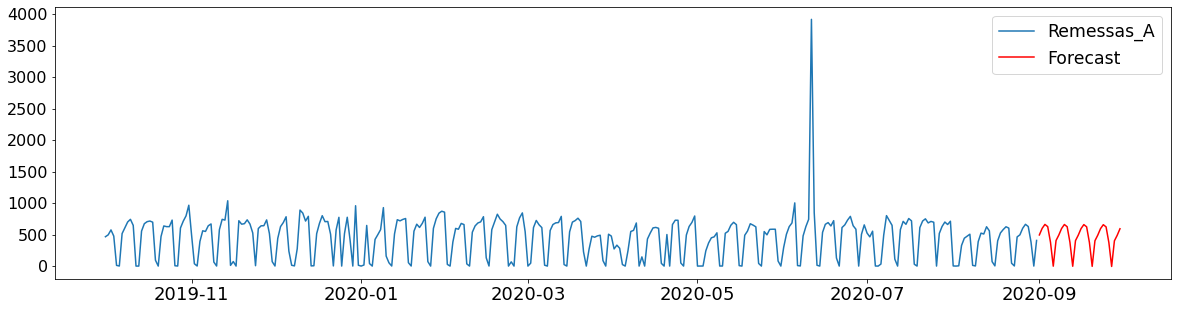

In [62]:
#plotando o forecast de setembro/2020
plt.figure(figsize=(20, 5))
plt.plot(df_test.Prediction.index, df_test[dependent_variable], label=dependent_variable)
plt.plot(df_test.Prediction.index, df_test['Prediction'], color='r', label='Forecast')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

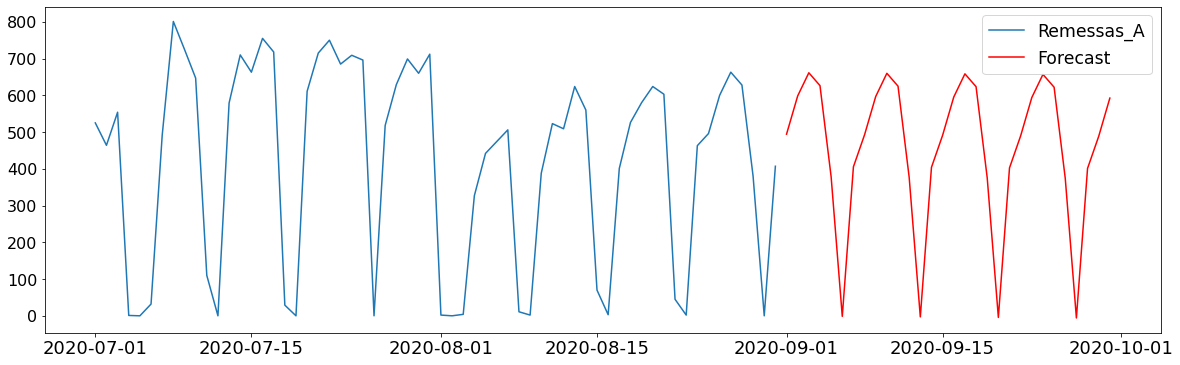

In [63]:
#zoom no gráfico anterior
df_plot = df_test.loc['2020-07-01':]
plt.figure(figsize=(20, 6))
plt.plot(df_plot.Prediction.index, df_plot[dependent_variable], label=dependent_variable)
plt.plot(df_plot.Prediction.index, df_plot['Prediction'], color='r', label='Forecast')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

Mais uma vez, observe como nosso modelo aprende o padrão encontrado nos 20 dias anteriores ao início do nosso forecast e reproduz esse padrão periodicamente ao longo do forecast. Não use esse modelo em produção!

# Outros clusters
Numa primeira abordagem, estou modelando cada cluster separadamente. Nesse notebook trabalhamos apenas o cluster A. Os demais clusters serão modelados em outros notebooks.

Numa próxima etapa modelaremos a interação das remessas (e volumes) entre os diferentes clusters.